In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from datetime import datetime

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.optimization.traders import Uniswapv3Arbitrageur

sns.set()

In [2]:
class GBMSimulator:
    def __init__(self, mu, sigma, s0, T, sim_len, seed=None):
        self.mu = mu
        self.sigma = sigma
        self.s0 = s0
        self.T = T
        self.sim_len = sim_len
        self.dt = T / (sim_len - 1)
        
        self.seed(seed=seed)

    def simulate(self):
        z = self._rng.normal(0, 1, self.sim_len - 1)
        x = (
                (self.mu - self.sigma ** 2 / 2) * self.dt
                + self.sigma * np.sqrt(self.dt) * z
        )
        sim = self.s0 * np.cumprod(np.exp(x))
        sim = np.concatenate([[self.s0], sim], axis=0)

        return sim.reshape(-1, 1)
    
    def seed(self, seed=None):
        self._rng = np.random.default_rng(seed)

In [3]:
SEED = 123
seed_seq = np.random.SeedSequence(SEED)
seeds = seed_seq.generate_state(10)

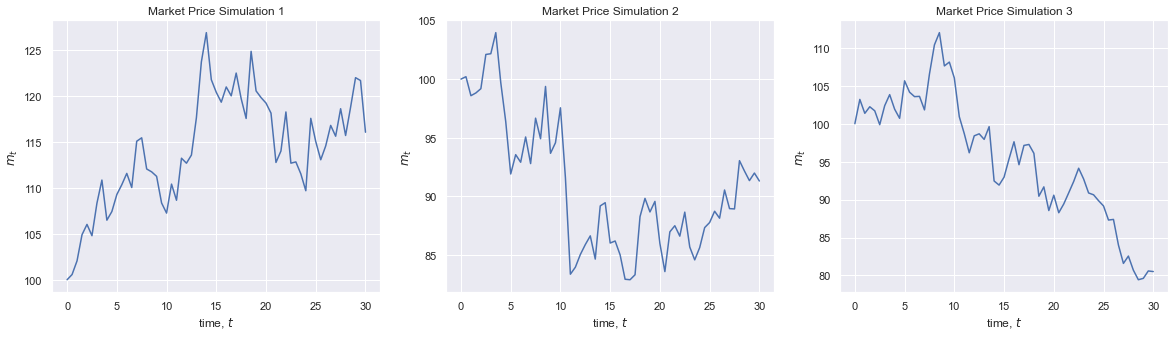

In [4]:
mu = 0.00
sigma = 0.20
m0 = 100
T = 1.0
sim_len = 60 + 1

gbm = GBMSimulator(mu, sigma, m0, T, sim_len, seed=seeds[0])
price_sims = [gbm.simulate().flatten() for _ in range(3)]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

t = np.linspace(0, 30, 60 + 1)
for i, sim in enumerate(price_sims):
    ax[i].plot(t, sim)
    ax[i].set_title(f'Market Price Simulation {i + 1}')
    ax[i].set_xlabel('time, $t$')
    ax[i].set_ylabel('$m_t$')
    
plt.show()

In [5]:
def arbitrage_to_price(pool, target_price, max_tries=10, fee_multiple=3):
    arbitrageur = Uniswapv3Arbitrageur()
    token0, token1, total_profit = 0, 0, 0
    
    for i in range(max_tries):
        pct_delta = target_price / pool.price - 1
        if abs(pct_delta) < fee_multiple * pool.fee:
            target = target_price
        else:
            target = pool.price * (1 + (pct_delta / 2))

        token, tokens_in = arbitrageur.get_swap(pool, target)
        if (tokens_in is None) or (tokens_in < 1e-12):
            break

        dx, dy = pool.swap(token, tokens_in)
        profit = arbitrageur.calc_profit(-dx, -dy, target_price)
        
        token0 += dx
        token1 += dy
        total_profit += profit
    
    if total_profit < 0:
        raise ValueError('Unprofitable arbitrage!')
    
    return token0, token1, total_profit

def arbitrage_simulation(pool, market_prices, liquidity_trade):
    prices = []
    for m in market_prices:
        step_prices = {'market_price': m}
        # move the pool price above the current market price
        _ = arbitrage_to_price(pool, m * (1 + liquidity_trade) / (1 - pool.fee))
        step_prices['liquidity_trade_high'] = pool.price
        
        # arbitrage back towards the current market price
        _ = arbitrage_to_price(pool, m)
        step_prices['price_high'] = pool.price
        
        # move the pool price below the current market price
        _ = arbitrage_to_price(pool, m * (1 - liquidity_trade) * (1 - pool.fee))
        step_prices['liquidity_trade_low'] = pool.price
        
        # arbitrage back towards the current market price
        _ = arbitrage_to_price(pool, m)
        step_prices['price_low'] = pool.price
        
        prices.append(step_prices)
        
    return prices

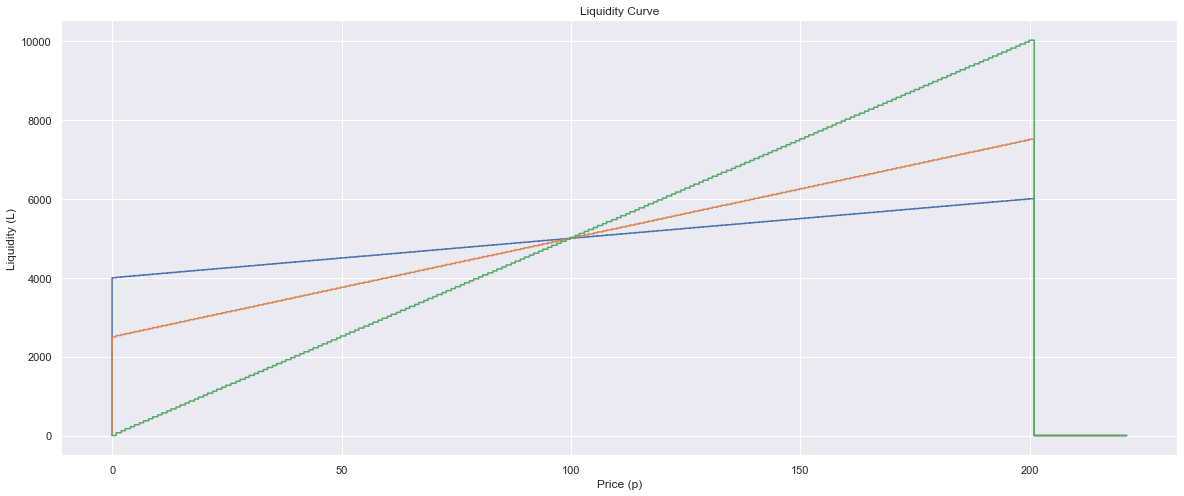

In [6]:
fee = 0.03
def liquidity_fn(p, alpha, beta):
    return alpha + beta * p

alpha = [4000, 2500, 0]
beta = [10, 25, 50]
pools = []

fig, ax = plt.subplots(figsize=(20, 8))

for ai, bi in zip(alpha, beta):
    pool = Uniswapv3Pool(fee, 1, m0)
    set_positions(pool, lambda p: liquidity_fn(p, ai, bi), 
                  1.0, 0.0, 200.0, min_liquidity=1)
    pools.append(pool)
    pool.plot_liquidity_curve(ax=ax)

plt.show()

In [7]:
all_prices = {}
liquidity_trade_shift = 0.10
for i in range(3):
    for j in range(3):
        prices = arbitrage_simulation(pools[i], price_sims[j], liquidity_trade_shift)
        all_prices[(i, j)] = prices

In [8]:
def plot_prices_and_bounds(prices, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))
    
    market_prices = np.array([pdict['market_price'] for pdict in prices])
    pool_low = np.array([pdict['price_low'] for pdict in prices])
    pool_high = np.array([pdict['price_high'] for pdict in prices])

    v2_bound_low = market_prices * (1 - fee)
    v2_bound_high = market_prices / (1 - fee)

    t = np.linspace(0, 30, 60 + 1)
    ax.plot(t, market_prices, label='Market Price', color='b')
    ax.fill_between(t, v2_bound_low, v2_bound_high, alpha=0.25)

    ax.plot(t, pool_low, label='Pool Lower/Upper Bound', color='r')
    ax.plot(t, pool_high, color='r')

    ax.set_title(f'Market Price Simulation With Pool Price Bound')
    ax.set_xlabel('time, $t$')
    ax.set_ylabel('$m_t$')
    ax.legend(loc='upper right')

    return ax

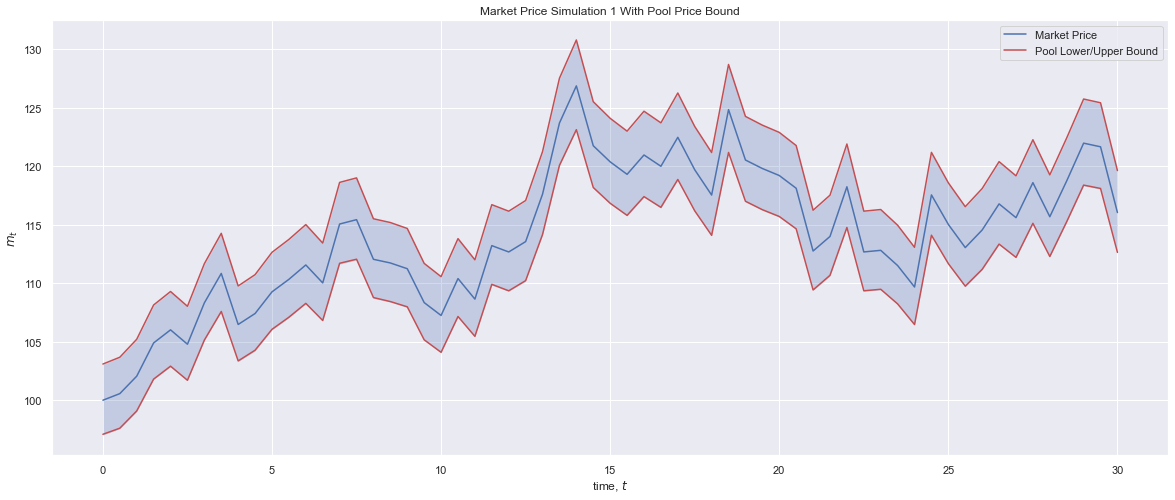

In [9]:
ax = plot_prices_and_bounds(all_prices[(2, 0)])
ax.set_title(f'Market Price Simulation {1} With Pool Price Bound')
plt.show()

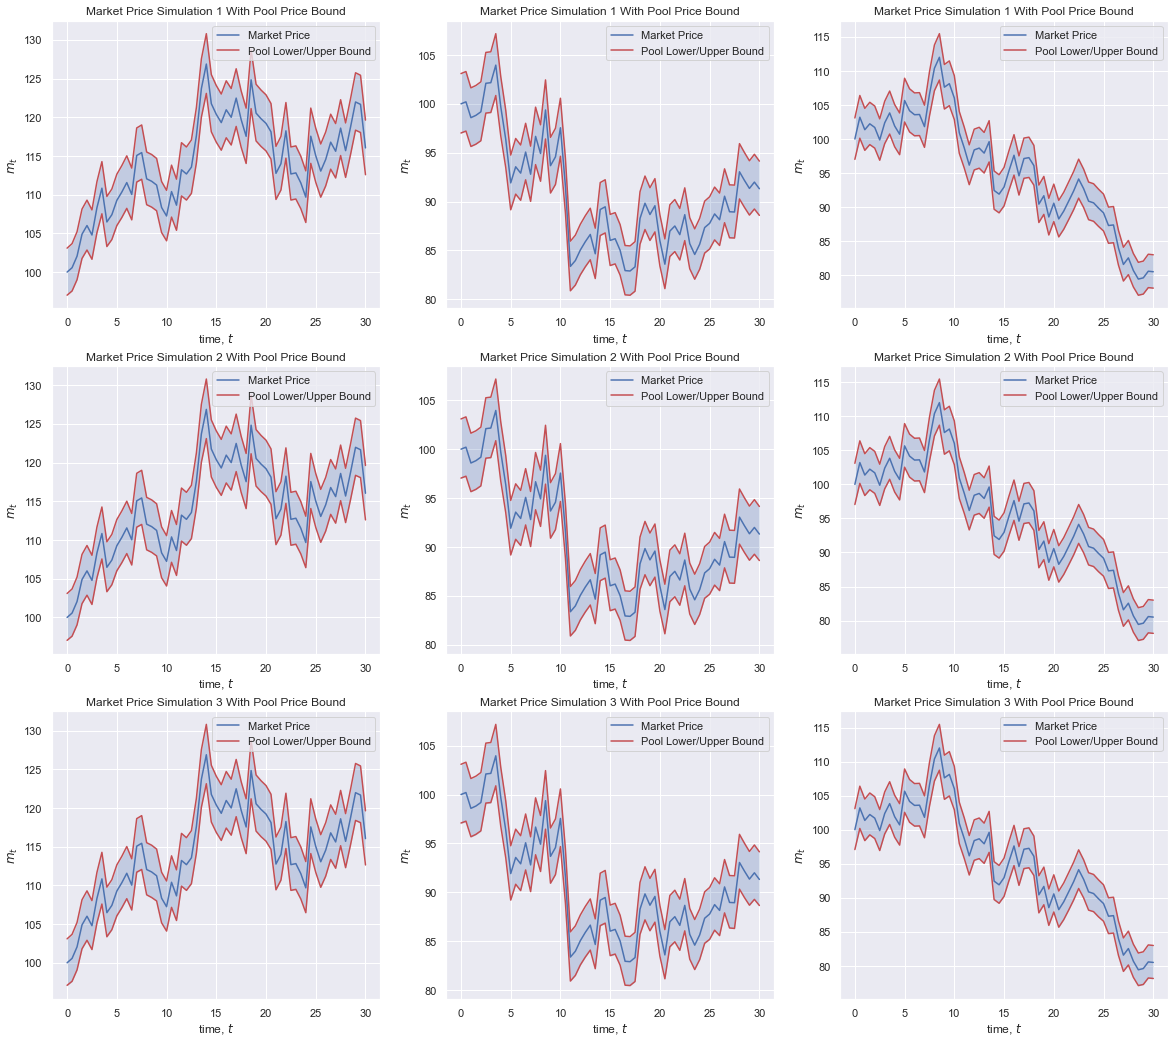

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20, 18))

for i in range(3):
    for j in range(3):
        prices = all_prices[(i, j)]
        plot_prices_and_bounds(prices, ax=ax[i][j])
        ax[i][j].set_title(f'Market Price Simulation {i + 1} With Pool Price Bound')

plt.show()

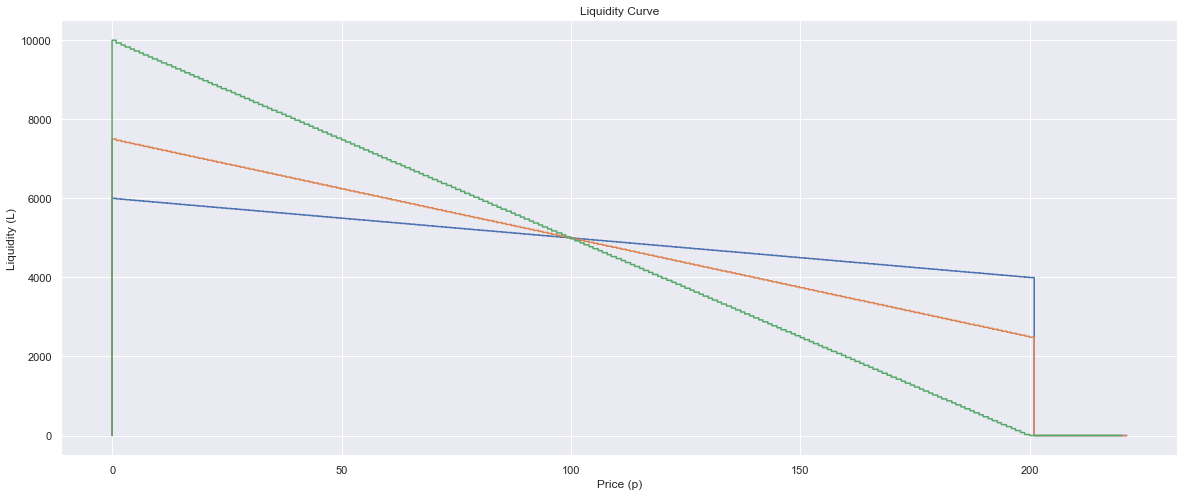

In [15]:
fee = 0.03
def liquidity_fn(p, alpha, beta):
    return alpha + beta * p

alpha = [6000, 7500, 10000]
beta = [-10, -25, -50]
pools = []

fig, ax = plt.subplots(figsize=(20, 8))

for ai, bi in zip(alpha, beta):
    pool = Uniswapv3Pool(fee, 1, m0)
    set_positions(pool, lambda p: liquidity_fn(p, ai, bi), 
                  1.0, 0.0, 200.0, min_liquidity=1)
    pools.append(pool)
    pool.plot_liquidity_curve(ax=ax)

plt.show()

In [16]:
all_prices = {}
liquidity_trade_shift = 0.10
for i in range(3):
    for j in range(3):
        prices = arbitrage_simulation(pools[i], price_sims[j], liquidity_trade_shift)
        all_prices[(i, j)] = prices

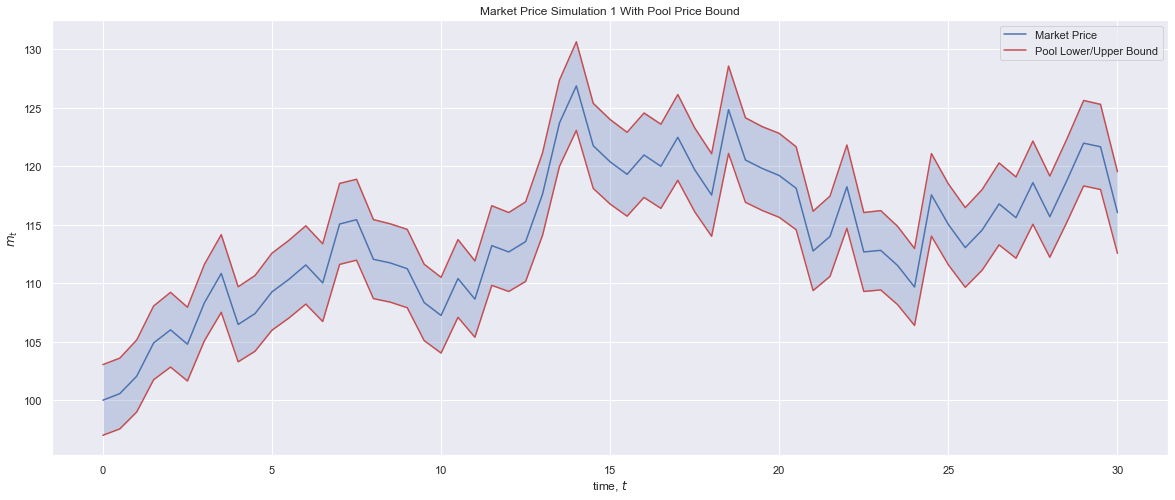

In [17]:
ax = plot_prices_and_bounds(all_prices[(2, 0)])
ax.set_title(f'Market Price Simulation {1} With Pool Price Bound')
plt.show()

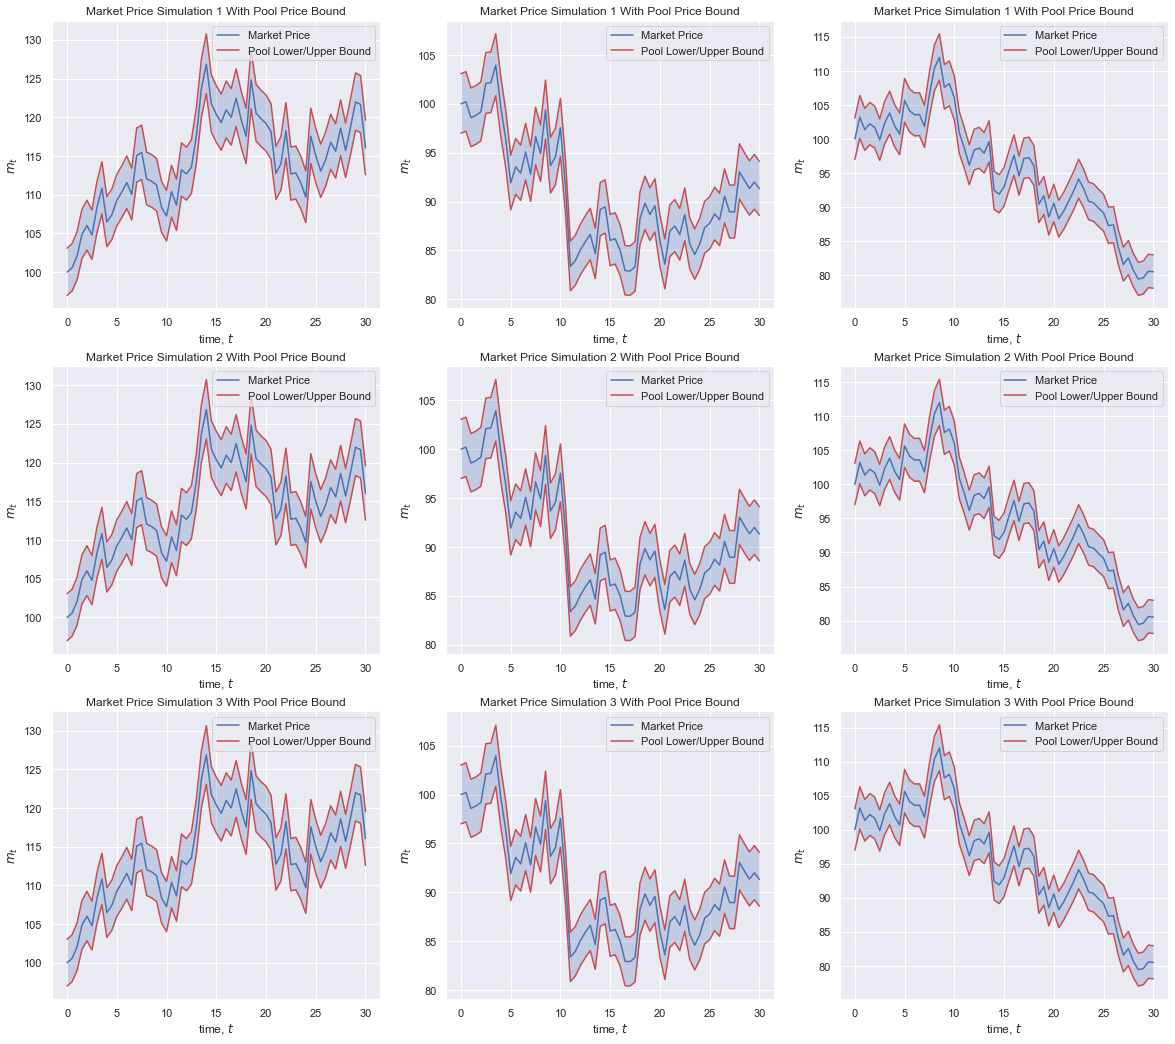

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(20, 18))

for i in range(3):
    for j in range(3):
        prices = all_prices[(i, j)]
        plot_prices_and_bounds(prices, ax=ax[i][j])
        ax[i][j].set_title(f'Market Price Simulation {i + 1} With Pool Price Bound')

plt.show()